# Softmax 练习

*补充并完成本练习。*

本练习类似于SVM练习，你要完成的事情包括:

- 为Softmax分类器实现完全矢量化的**损失函数**
- 实现其**解析梯度（analytic gradient）**的完全矢量化表达式
- 用数值梯度**检查你的代码**
- 使用验证集**调整学习率和正则化强度**
- 使用**SGD优化**损失函数
- **可视化**最终学习的权重


In [1]:
import random
import numpy as np
from daseCV.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'daseCV/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax 分类器

请在**daseCV/classifiers/softmax.py**中完成本节的代码。

In [ ]:
# 首先使用嵌套循环实现简单的softmax损失函数。
# 打开文件 daseCV/classifiers/softmax.py 并补充完成
# softmax_loss_naive 函数.

from daseCV.classifiers.softmax import softmax_loss_naive
import time

# 生成一个随机的softmax权重矩阵，并使用它来计算损失。
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

**问题 1**


为什么我们期望损失接近-log（0.1）？简要说明。

$\color{blue}{\textit 答:}$ *因为输入数据共有10类，而使用的softmax权重矩阵是随机生成的且矩阵值很小，所以在预测图像类别时，接近于从10个类别中随机选择，因此期望预测准确率为0.1，所以期望损失接近-log（0.1）。* 



In [4]:
# 完成softmax_loss_naive，并实现使用嵌套循环的梯度的版本(naive)。
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# 就像SVM那样，请使用数值梯度检查作为调试工具。
# 数值梯度应接近分析梯度。
from daseCV.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# 与SVM情况类似，使用正则化进行另一个梯度检查
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.551577 analytic: 0.551577, relative error: 9.814062e-09
numerical: 1.336112 analytic: 1.336111, relative error: 4.588922e-08
numerical: -0.638078 analytic: -0.638078, relative error: 1.208100e-07
numerical: 1.548644 analytic: 1.548644, relative error: 7.901156e-09
numerical: -0.926155 analytic: -0.926155, relative error: 4.567679e-08
numerical: 0.117447 analytic: 0.117447, relative error: 7.096929e-07
numerical: -4.956643 analytic: -4.956643, relative error: 5.212582e-09
numerical: 0.095010 analytic: 0.095010, relative error: 4.218716e-07
numerical: 2.458320 analytic: 2.458320, relative error: 8.896537e-09
numerical: -0.194659 analytic: -0.194659, relative error: 1.589420e-07
numerical: 0.906134 analytic: 0.906134, relative error: 4.906966e-08
numerical: 0.679198 analytic: 0.679198, relative error: 1.096685e-07
numerical: 2.486053 analytic: 2.486053, relative error: 1.898996e-08
numerical: 0.018842 analytic: 0.018842, relative error: 1.135823e-06
numerical: -0.893978 analy

In [5]:
# 现在，我们有了softmax损失函数及其梯度的简单实现，
# 接下来要在 softmax_loss_vectorized 中完成一个向量化版本.
# 这两个版本应计算出相同的结果，但矢量化版本应更快。
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from daseCV.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# 正如前面在SVM练习中所做的一样，我们使用Frobenius范数比较两个版本梯度。
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.377641e+00 computed in 0.883880s
vectorized loss: 2.377641e+00 computed in 0.094105s
Loss difference: 0.000000
Gradient difference: 0.000000


In [13]:
# 使用验证集调整超参数（正则化强度和学习率）。您应该尝试不同的学习率和正则化强度范围; 
# 如果您小心的话，您应该能够在验证集上获得超过0.35的精度。
from daseCV.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = np.linspace(3.5e-7, 4.5e-7, 6)  # 逐步缩小范围
regularization_strengths = np.linspace(0.8e4, 1.2e4, 5)  # 逐步缩小范围

################################################################################
# 需要完成的事:                                                                        
# 对验证集设置学习率和正则化强度。
# 这与之前SVM中做的类似；
# 保存训练效果最好的softmax分类器到best_softmax中。
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, lr, rs, num_iters=1000)
        
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, rs)] = train_accuracy, val_accuracy
        
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)  # lr 4.000000e-07 reg 1.000000e+04

lr 3.500000e-07 reg 8.000000e+03 train accuracy: 0.378224 val accuracy: 0.390000
lr 3.500000e-07 reg 9.000000e+03 train accuracy: 0.374939 val accuracy: 0.390000
lr 3.500000e-07 reg 1.000000e+04 train accuracy: 0.372102 val accuracy: 0.385000
lr 3.500000e-07 reg 1.100000e+04 train accuracy: 0.370816 val accuracy: 0.383000
lr 3.500000e-07 reg 1.200000e+04 train accuracy: 0.369265 val accuracy: 0.384000
lr 3.700000e-07 reg 8.000000e+03 train accuracy: 0.375449 val accuracy: 0.396000
lr 3.700000e-07 reg 9.000000e+03 train accuracy: 0.374184 val accuracy: 0.384000
lr 3.700000e-07 reg 1.000000e+04 train accuracy: 0.374755 val accuracy: 0.382000
lr 3.700000e-07 reg 1.100000e+04 train accuracy: 0.371122 val accuracy: 0.389000
lr 3.700000e-07 reg 1.200000e+04 train accuracy: 0.367122 val accuracy: 0.372000
lr 3.900000e-07 reg 8.000000e+03 train accuracy: 0.374633 val accuracy: 0.386000
lr 3.900000e-07 reg 9.000000e+03 train accuracy: 0.370245 val accuracy: 0.363000
lr 3.900000e-07 reg 1.000000

In [7]:
from daseCV.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

lr = 1e-06
rs = 1e+03
num_iters = [1600, 1800, 2000, 2200, 2400]

for ni in num_iters:
    softmax = Softmax()
    softmax.train(X_train, y_train, lr, rs, num_iters=ni)
        
    y_train_pred = softmax.predict(X_train)
    train_accuracy = np.mean(y_train == y_train_pred)
    y_val_pred = softmax.predict(X_val)
    val_accuracy = np.mean(y_val == y_val_pred)
    results[(ni)] = train_accuracy, val_accuracy
        
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_softmax = softmax

for ni in sorted(results):
    train_accuracy, val_accuracy = results[(ni)]
    print('num_iters %e train accuracy: %f val accuracy: %f' % (
                ni, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

num_iters 1.600000e+03 train accuracy: 0.406898 val accuracy: 0.397000
num_iters 1.800000e+03 train accuracy: 0.404735 val accuracy: 0.399000
num_iters 2.000000e+03 train accuracy: 0.407408 val accuracy: 0.398000
num_iters 2.200000e+03 train accuracy: 0.408735 val accuracy: 0.410000
num_iters 2.400000e+03 train accuracy: 0.412551 val accuracy: 0.407000
best validation accuracy achieved during cross-validation: 0.410000


In [4]:
# 在测试集上评估
# 在测试集上评估最好的softmax
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.387000


**问题 2** - *对或错*

假设总训练损失定义为所有训练样本中每个数据点损失的总和。可能会有新的数据点添加到训练集中，同时SVM损失保持不变，但是对于Softmax分类器的损失而言，情况并非如此。

$\color{blue}{\textit 你的回答:}$ *对。*


$\color{blue}{\textit 你的解释:}$ *SVM损失和Softmax损失的计算公式分别如下所示：*
$$
SVM\ loss: L_i = \sum_{j\neq{y_i}}max(0,s_{j}-s_{y_i}+1)
$$
$$
Softmax\ loss: L_i = -log\left(\frac{e^{s_{y_i}}}{\sum_{j}e^{s_j}}\right)
$$
*如果有新的数据点添加到训练集中，只要对于错误标签的预测分数比对于正确标签的预测分数低1以上，那么其新添的SVM损失就为0，所以SVM损失就会保持不变。*

*如果有新的数据点添加到训练集中，将影响每个类别的概率分布，而Softmax损失是基于类别概率计算而得的，所以Softmax损失一定会发生改变。*

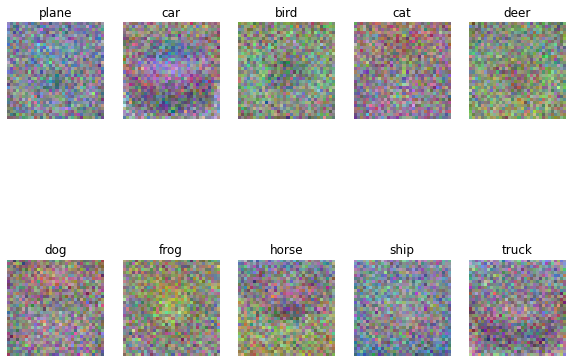

In [15]:
# 可视化每个类别的学习到的权重
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Data for leaderboard
这里额外提供了一组未给标签的测试集X，用于leaderborad上的竞赛。

---
提示：该题的目的是鼓励同学们探索能够提升模型性能的方法。

In [8]:
# leaderboard的测试数据
X = np.load("./input/X_3073.npy")
################################################################################
# 需要完成的事情: 
# 找到更合适的softmax
# 提示：如果你不想花时间，你也可以直接使用上面已经训练好的best_softmax。                   
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
softmax_leaderboard = best_softmax
preds = softmax_leaderboard.predict(X)

提醒：运行完下面代码之后，点击下面的submit，然后去leaderboard上查看你的成绩。本模型对应的成绩在phase3的leaderboard中。

In [9]:
import os
#输出格式
def output_file(preds, phase_id=3):
    path=os.getcwd()
    if not os.path.exists(path + '/output/phase_{}'.format(phase_id)):
        os.mkdir(path + '/output/phase_{}'.format(phase_id))
    path=path + '/output/phase_{}/prediction.npy'.format(phase_id)
    np.save(path,preds)
def zip_fun(phase_id=3):
    path=os.getcwd()
    output_path = path + '/output'
    files = os.listdir(output_path)
    for _file in files:
        if _file.find('zip') != -1:
            os.remove(output_path + '/' + _file)
    newpath=path+'/output/phase_{}'.format(phase_id)
    os.chdir(newpath)
    cmd = 'zip ../prediction_phase_{}.zip prediction.npy'.format(phase_id)
    os.system(cmd)
    os.chdir(path)
output_file(preds)
zip_fun()